# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

Student Name: Mingyun Zhang

I have used the following AI tools: CHATGPT

I understand that my submission needs to be my own work: MYZ

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.

In Visual Studio Code: Use Export (click on ... in the menu bar) to save your notebook as a HTML file.

In Colab you need to save the notebook on GoogleDrive and then add the following block

In [642]:
%%capture
!pip install nbconvert

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Copy_of_robot_vacuum_Mingyun.ipynb

You will need to fix the file location on your GoogleDrive.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [580]:
# make sure numpy is installed
!pip install -q numpy

In [581]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [582]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a different performance measure than the one specified in the PEAS description! Since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room. Your implementation needs to implement the **correct performance measure.** The energy budget of the agent is specified as `max_steps`.

In [583]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [584]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: east
step 2 - action: west
step 3 - action: south
step 4 - action: suck
step 5 - action: east
step 6 - action: east
step 7 - action: east
step 8 - action: east
step 9 - action: suck
step 10 - action: west
step 11 - action: east
step 12 - action: suck
step 13 - action: suck
step 14 - action: suck
step 15 - action: west
step 16 - action: west
step 17 - action: east
step 18 - action: east
step 19 - action: south


5

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable. For example, long lines may get cut off. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [612]:
import numpy as np

def initialize_room(n=5, p=0.2):
    return np.random.rand(n, n) < p

def is_room_clean(room):
    return not room.any()

def simulate_environment(agent, n=5, p=0.2, max_steps=1000, verbose=False):
    room = initialize_room(n, p)
    agent_position = np.random.randint(0, n, size=2)  # Random starting position
    actions_count = 0
    cleaning_count = 0

    while actions_count < max_steps:
        current_pos = tuple(agent_position)
        dirty = room[current_pos]
        bumpers = {
            "north": agent_position[0] == 0,
            "east": agent_position[1] == n - 1,
            "south": agent_position[0] == n - 1,
            "west": agent_position[1] == 0
        }

        action = agent(bumpers, dirty)
        if action == "suck" and dirty:
            room[current_pos] = False
            cleaning_count += 1
        elif action in ["north", "east", "south", "west"]:
            move_dict = {"north": (-1, 0), "east": (0, 1), "south": (1, 0), "west": (0, -1)}
            if not bumpers[action]:
                agent_position += np.array(move_dict[action])

        actions_count += 1

        if is_room_clean(room):
            if verbose:
                print(f"The room is clean! Total cleanings: {cleaning_count}, Total Steps : {actions_count}.")
            break  # Room is clean, exit early

        if verbose:
            print(f"Step {actions_count} - Position {agent_position} - Action: {action}")

    return actions_count , cleaning_count


In [613]:
steps_used = simulate_environment(simple_randomized_agent, max_steps=100, verbose=True)
print(f"Total steps used by the agent: {steps_used}")

Step 1 - Position [0 3] - Action: north
Step 2 - Position [0 3] - Action: north
Step 3 - Position [0 3] - Action: north
Step 4 - Position [0 4] - Action: east
Step 5 - Position [0 4] - Action: east
Step 6 - Position [0 3] - Action: west
Step 7 - Position [1 3] - Action: south
Step 8 - Position [1 3] - Action: suck
Step 9 - Position [1 2] - Action: west
Step 10 - Position [0 2] - Action: north
Step 11 - Position [0 2] - Action: suck
Step 12 - Position [0 1] - Action: west
Step 13 - Position [0 0] - Action: west
Step 14 - Position [0 0] - Action: west
Step 15 - Position [0 0] - Action: north
Step 16 - Position [0 0] - Action: suck
Step 17 - Position [1 0] - Action: south
Step 18 - Position [1 0] - Action: west
Step 19 - Position [1 0] - Action: west
Step 20 - Position [2 0] - Action: south
Step 21 - Position [3 0] - Action: south
Step 22 - Position [4 0] - Action: south
Step 23 - Position [4 0] - Action: suck
Step 24 - Position [4 1] - Action: east
Step 25 - Position [4 2] - Action: east

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function. Use the function signature for the `simple_randomized_agent` function above.

In [614]:
def simple_reflex_agent(bumpers, dirty):
    if dirty:
        return "suck"
    else:
        # Basic reflex: go in a random direction away from walls
        return np.random.choice([action for action in ["north", "east", "south", "west"] if not bumpers[action]])

# Example usage of the simple reflex agent function
steps_used = simulate_environment(simple_reflex_agent, max_steps=100, verbose=True)

print(f"Total steps used by the agent: {steps_used}")

Step 1 - Position [4 1] - Action: west
Step 2 - Position [3 1] - Action: north
Step 3 - Position [3 0] - Action: west
Step 4 - Position [2 0] - Action: north
Step 5 - Position [3 0] - Action: south
Step 6 - Position [3 1] - Action: east
Step 7 - Position [4 1] - Action: south
Step 8 - Position [4 0] - Action: west
Step 9 - Position [4 1] - Action: east
Step 10 - Position [4 2] - Action: east
Step 11 - Position [4 3] - Action: east
Step 12 - Position [4 2] - Action: west
Step 13 - Position [4 3] - Action: east
Step 14 - Position [4 2] - Action: west
Step 15 - Position [4 3] - Action: east
Step 16 - Position [4 4] - Action: east
Step 17 - Position [3 4] - Action: north
Step 18 - Position [3 3] - Action: west
Step 19 - Position [2 3] - Action: north
Step 20 - Position [3 3] - Action: south
Step 21 - Position [4 3] - Action: south
Step 22 - Position [4 2] - Action: west
Step 23 - Position [4 1] - Action: west
Step 24 - Position [3 1] - Action: north
Step 25 - Position [3 2] - Action: east


## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [587]:
# Your short description of the state and your implementation goes here

Here are the properties of each agent in the initialization function:
Current Position: The current position of the agent on the grid.
Visited Squares: The set of squares that the agent has visited, ensuring that it does not revisit unnecessary locations.
Clean Trash: Whether all the trash has been cleaned up.
Agent Workflow:
1. Initialization: The agent starts at (0, 0) and tries to reach the top left corner.
2. Cleaning Phase: After finding a corner, the agent explores the room, moving in a snake-like manner, cleaning dirty squares, and avoiding revisiting cleaned locations.
3. Stop: The agent continues until there are no more valid moves, at which point the agent stops and marks the room as completely cleaned.

This setup provides a structured way to systematically explore all areas of the room, clean as needed, and efficiently backtrack to cover any missed areas.

In [588]:
class model_based_reflex_agent:
    def __init__(self):
        self.position = None
        self.phase = 'find_corner'
        self.direction = 'east'
        self.visited = set()
        self.cleaned_all = False  # Track if the room is fully cleaned

    def __call__(self, bumpers, dirty):
        if self.cleaned_all:
            return  # Stop once the room is fully cleaned

        if self.position is None:
            self.position = (0, 0)  # Relative starting position
            self.phase = 'find_corner'
            self.visited.add(self.position)

        if self.phase == 'find_corner':
            # Move west until bumping into a wall
            if not bumpers['west']:
                self.update_position('west')
                self.visited.add(self.position)
                return 'west'
            # Move north until bumping into a wall
            elif not bumpers['north']:
                self.update_position('north')
                self.visited.add(self.position)
                return 'north'
            else:
                # Reached the top-left corner, reset position to (0, 0)
                self.position = (0, 0)
                self.phase = 'explore'
                self.direction = 'east'
                self.visited = set()
                self.visited.add(self.position)

        if dirty:
            return 'suck'

        # During exploration phase, traverse in a serpentine pattern
        if self.phase == 'explore':
            next_direction = self.direction
            delta = self.get_delta(next_direction)
            next_position = (self.position[0] + delta[0], self.position[1] + delta[1])

            if not bumpers[next_direction] and next_position not in self.visited:
                # Can move in the current direction
                self.update_position(next_direction)
                self.visited.add(self.position)
                return next_direction
            else:
                # Cannot move in the current direction, try moving south one row
                if not bumpers['south']:
                    self.update_position('south')
                    self.visited.add(self.position)
                    # Reverse the movement direction to implement serpentine traversal
                    self.direction = 'west' if self.direction == 'east' else 'east'
                    return 'south'
                else:
                    self.cleaned_all = True  # Stop the agent if it has no more moves
                    return

    def update_position(self, direction):
        delta = self.get_delta(direction)
        if delta is None:
            print(f"Error: Invalid direction '{direction}'")
        self.position = (self.position[0] + delta[0], self.position[1] + delta[1])

    def get_delta(self, direction):
        deltas = {
            'north': (-1, 0),
            'east': (0, 1),
            'south': (1, 0),
            'west': (0, -1)
        }
        return deltas.get(direction, None)  # Return None if the direction is invalid


In [589]:
agent = model_based_reflex_agent()

steps_taken, cleanings = simulate_environment(agent, n=5, p=0.2, max_steps=1000, verbose=True)

Step 1 - Position [1 3] - Action: west
Step 2 - Position [1 2] - Action: west
Step 3 - Position [1 1] - Action: west
Step 4 - Position [1 0] - Action: west
Step 5 - Position [0 0] - Action: north
Step 6 - Position [0 1] - Action: east
Step 7 - Position [0 2] - Action: east
Step 8 - Position [0 3] - Action: east
Step 9 - Position [0 3] - Action: suck
Step 10 - Position [0 4] - Action: east
Step 11 - Position [1 4] - Action: south
Step 12 - Position [1 3] - Action: west
Step 13 - Position [1 2] - Action: west
Step 14 - Position [1 1] - Action: west
Step 15 - Position [1 1] - Action: suck
Step 16 - Position [1 0] - Action: west
Step 17 - Position [2 0] - Action: south
Step 18 - Position [2 1] - Action: east
Step 19 - Position [2 2] - Action: east
Step 20 - Position [2 3] - Action: east
Step 21 - Position [2 4] - Action: east
Step 22 - Position [3 4] - Action: south
Step 23 - Position [3 3] - Action: west
Step 24 - Position [3 2] - Action: west
Step 25 - Position [3 1] - Action: west
Step 

## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

In [605]:
grid_size = 5
dirt_probability = 0.2
max_steps_list = [500]
runs = 100

# Data structure to store results
result_5 = {'Randomized Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
            'Simple Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
            'Model-based Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list}}

for max_steps in max_steps_list:
    for _ in range(runs):
        # Randomized Agent
        actions_count, cleaning_count = simulate_environment(simple_randomized_agent, n=grid_size, p=dirt_probability, max_steps=max_steps)
        result_5['Randomized Agent'][max_steps]['steps'].append(actions_count)
        result_5['Randomized Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Simple Reflex Agent
        actions_count, cleaning_count = simulate_environment(simple_reflex_agent, n=grid_size, p=dirt_probability, max_steps=max_steps)
        result_5['Simple Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_5['Simple Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Model-based Reflex Agent
        agent = model_based_reflex_agent()
        actions_count, cleaning_count = simulate_environment(agent, n=grid_size, p=dirt_probability, max_steps=max_steps)
        result_5['Model-based Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_5['Model-based Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)


print(f"---------------- 5X5 average_steps_number ----------------")
for agent_type, data in result_5.items():
    for max_step, steps in data.items():
        average_steps = sum(steps['steps']) / len(steps['steps'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Steps: {average_steps:.2f}")


print(f"----------------5X5  average_cleaning_number ----------------")
for agent_type, data in result_5.items():
    for max_step, cleanings in data.items():
        average_cleaning = sum(cleanings['cleanings']) / len(cleanings['cleanings'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Cleaning Count: {average_cleaning:.2f}")


grid_size = 10
dirt_probability = 0.2
max_steps_list = [5000]
runs = 100

# Data structure to store results
result_10 = {
    'Randomized Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
    'Simple Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
    'Model-based Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list}
}

for max_steps in max_steps_list:
    for _ in range(runs):
        # Randomized Agent
        actions_count, cleaning_count = simulate_environment(
            simple_randomized_agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_10['Randomized Agent'][max_steps]['steps'].append(actions_count)
        result_10['Randomized Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Simple Reflex Agent
        actions_count, cleaning_count = simulate_environment(
            simple_reflex_agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_10['Simple Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_10['Simple Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Model-based Reflex Agent
        agent = model_based_reflex_agent()
        actions_count, cleaning_count = simulate_environment(
            agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_10['Model-based Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_10['Model-based Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

print(f"---------------- 10X10 average_steps_number ----------------")
for agent_type, data in result_10.items():
    for max_step, steps in data.items():
        average_steps = sum(steps['steps']) / len(steps['steps'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Steps: {average_steps:.2f}")

print(f"---------------- 10X10 average_cleaning_number ----------------")
for agent_type, data in result_10.items():
    for max_step, cleanings in data.items():
        average_cleaning = sum(cleanings['cleanings']) / len(cleanings['cleanings'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Cleaning Count: {average_cleaning:.2f}")



grid_size = 100
dirt_probability = 0.2
max_steps_list = [30000]
runs = 100


result_100 = {
    'Randomized Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
    'Simple Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
    'Model-based Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list}
}

for max_steps in max_steps_list:
    for _ in range(runs):
        # Randomized Agent
        actions_count, cleaning_count = simulate_environment(
            simple_randomized_agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_100['Randomized Agent'][max_steps]['steps'].append(actions_count)
        result_100['Randomized Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Simple Reflex Agent
        actions_count, cleaning_count = simulate_environment(
            simple_reflex_agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_100['Simple Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_100['Simple Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

        # Model-based Reflex Agent
        agent = model_based_reflex_agent()
        actions_count, cleaning_count = simulate_environment(
            agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_100['Model-based Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_100['Model-based Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

print(f"---------------- 100 x 100 average_steps_number ----------------")
for agent_type, data in result_100.items():
    for max_step, steps in data.items():
        average_steps = sum(steps['steps']) / len(steps['steps']) if steps['steps'] else 0
        print(f"{agent_type}, Max Steps: {max_step}, Average Steps: {average_steps:.2f}")


print(f"---------------- 100 x 100  average_cleaning_number ----------------")
for agent_type, data in result_100.items():
    for max_step, cleanings in data.items():
        average_cleaning = sum(cleanings['cleanings']) / len(cleanings['cleanings']) if cleanings['cleanings'] else 0
        print(f"{agent_type}, Max Steps: {max_step}, Average Cleaning Count: {average_cleaning:.2f}")



---------------- average_steps_number ----------------
Randomized Agent, Max Steps: 500, Average Steps: 363.66
Simple Reflex Agent, Max Steps: 500, Average Steps: 106.89
Model-based Reflex Agent, Max Steps: 500, Average Steps: 29.77
---------------- average_cleaning_number ----------------
Randomized Agent, Max Steps: 500, Average Cleaning Count: 4.74
Simple Reflex Agent, Max Steps: 500, Average Cleaning Count: 4.92
Model-based Reflex Agent, Max Steps: 500, Average Cleaning Count: 5.14
---------------- average_steps_number ----------------
Randomized Agent, Max Steps: 5000, Average Steps: 3024.12
Simple Reflex Agent, Max Steps: 5000, Average Steps: 886.24
Model-based Reflex Agent, Max Steps: 5000, Average Steps: 125.42
---------------- average_cleaning_number ----------------
Randomized Agent, Max Steps: 5000, Average Cleaning Count: 19.94
Simple Reflex Agent, Max Steps: 5000, Average Cleaning Count: 20.49
Model-based Reflex Agent, Max Steps: 5000, Average Cleaning Count: 20.31
-------

In [610]:
import pandas as pd
def calculate_averages(result_dict):
    averages = {}
    for agent_type, data in result_dict.items():
        for max_step, steps in data.items():
            average_steps = sum(steps['steps']) / len(steps['steps']) if steps['steps'] else 0
            averages[agent_type] = average_steps
    return averages

# Getting averages for each grid size
average_5x5 = calculate_averages(result_5)
average_10x10 = calculate_averages(result_10)
average_100x100 = calculate_averages(result_100)

# Creating the dynamic DataFrame with the correct average values
data_dynamic = {
    'Size': ['5x5', '10x10', '100x100'],
    'Randomized Agent': [average_5x5['Randomized Agent'], average_10x10['Randomized Agent'], average_100x100['Randomized Agent']],
    'Simple Reflex Agent': [average_5x5['Simple Reflex Agent'], average_10x10['Simple Reflex Agent'], average_100x100['Simple Reflex Agent']],
    'Model-based Reflex Agent': [average_5x5['Model-based Reflex Agent'], average_10x10['Model-based Reflex Agent'], average_100x100['Model-based Reflex Agent']]
}

# Creating a DataFrame
df_dynamic_results = pd.DataFrame(data_dynamic)

print(df_dynamic_results)

      Size  Randomized Agent  Simple Reflex Agent  Model-based Reflex Agent
0      5x5            363.66               106.89                     29.77
1    10x10           3024.12               886.24                    125.42
2  100x100          50000.00             50000.00                  12091.66


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | 363.66 |  106.89   | 29.77 |
| 10x10   |  2840.36 | 886.24  | 125.42 |
| 100x100 | 50000.00| 50000.00| 12091.66 |

Add charts to compare the performance of the different agents.

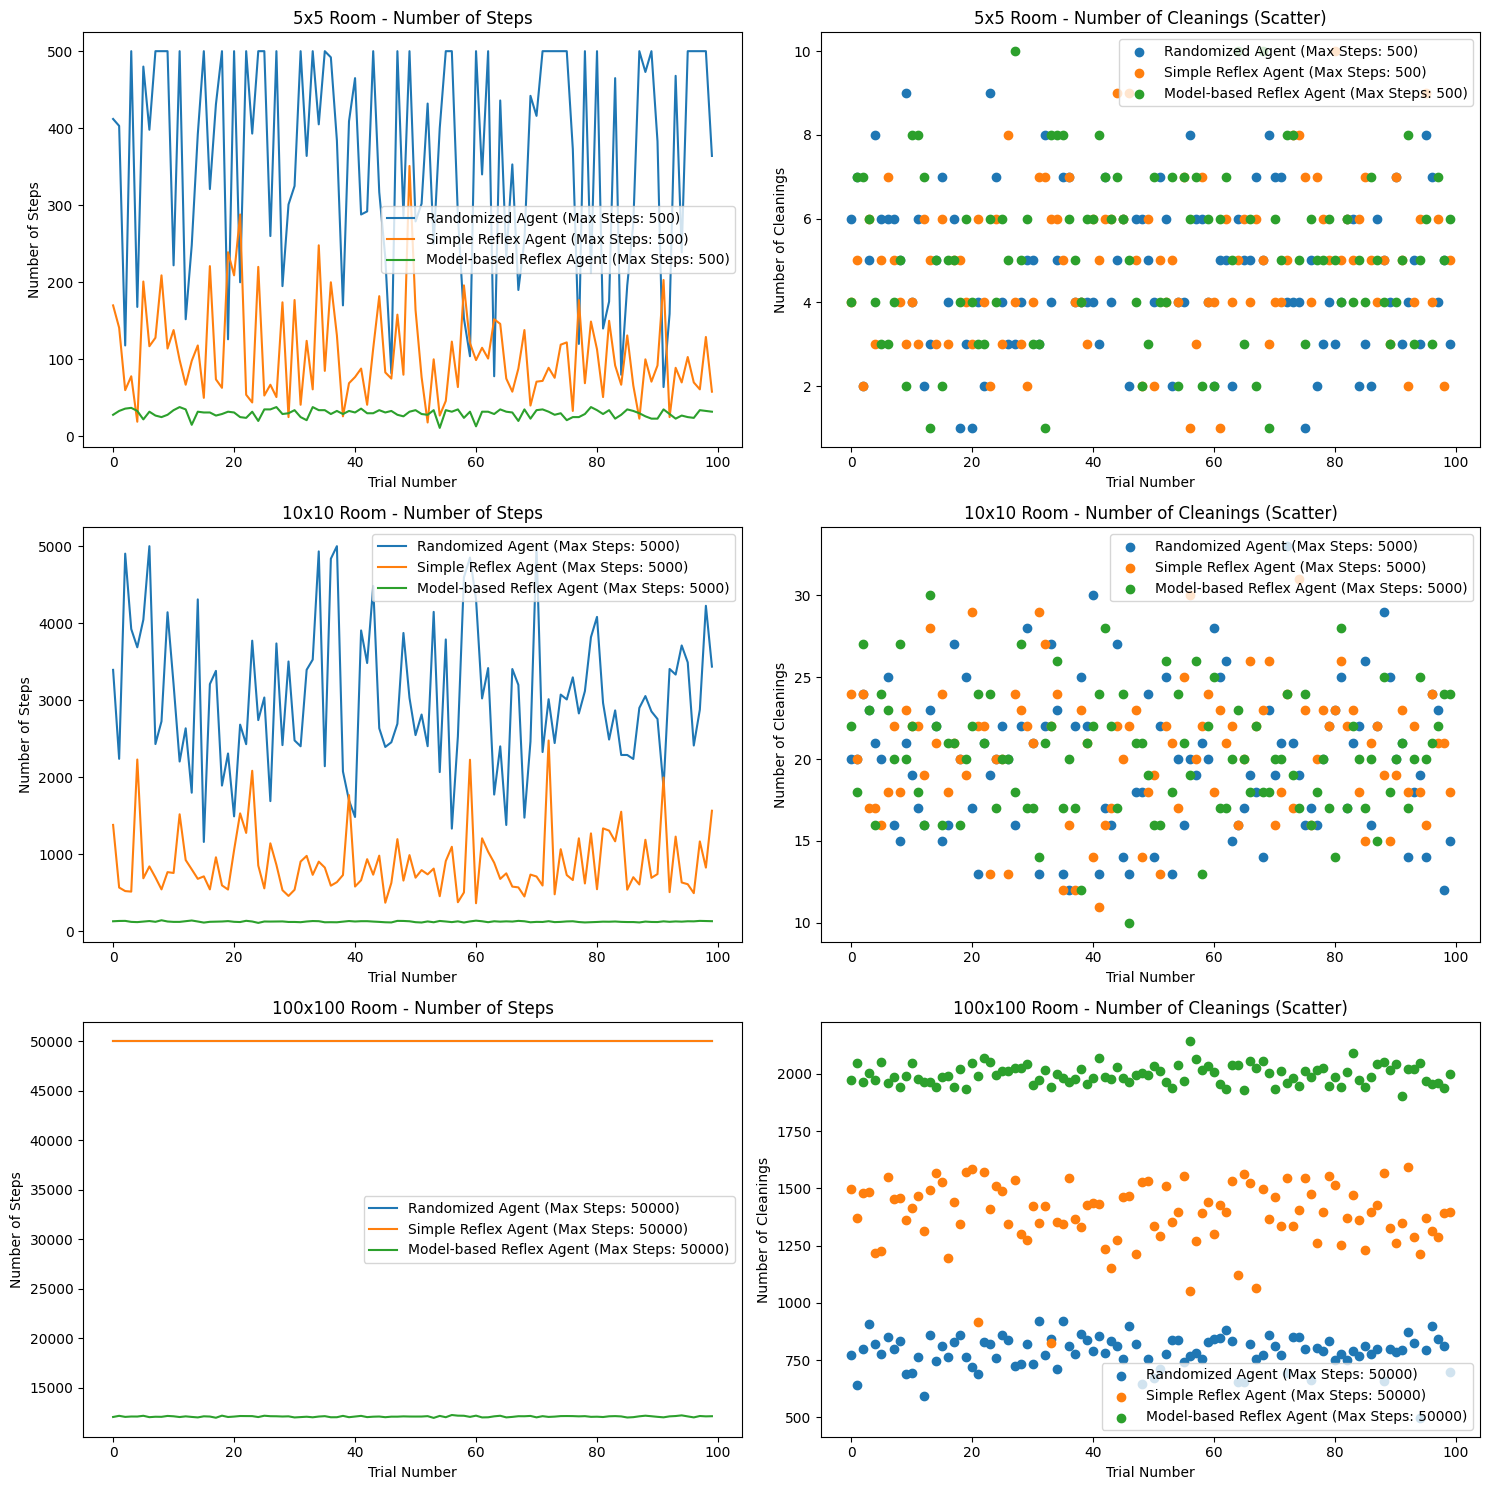

In [615]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Line plot for result_5 (5x5 room) - steps
for agent_type, data in result_5.items():
    for max_step, result in data.items():
        axs[0, 0].plot(result['steps'], label=f"{agent_type} (Max Steps: {max_step})")

axs[0, 0].set_title("5x5 Room - Number of Steps")
axs[0, 0].set_xlabel("Trial Number")
axs[0, 0].set_ylabel("Number of Steps")
axs[0, 0].legend()

# Scatter plot for result_5 (5x5 room) - cleanings
for agent_type, data in result_5.items():
    for max_step, result in data.items():
        axs[0, 1].scatter(range(len(result['cleanings'])), result['cleanings'], label=f"{agent_type} (Max Steps: {max_step})")

axs[0, 1].set_title("5x5 Room - Number of Cleanings (Scatter)")
axs[0, 1].set_ylabel("Number of Cleanings")
axs[0, 1].set_xlabel("Trial Number")
axs[0, 1].legend()

# Line plot for result_10 (10x10 room) - steps
for agent_type, data in result_10.items():
    for max_step, result in data.items():
        axs[1, 0].plot(result['steps'], label=f"{agent_type} (Max Steps: {max_step})")

axs[1, 0].set_title("10x10 Room - Number of Steps")
axs[1, 0].set_xlabel("Trial Number")
axs[1, 0].set_ylabel("Number of Steps")
axs[1, 0].legend()

# Scatter plot for result_10 (10x10 room) - cleanings
for agent_type, data in result_10.items():
    for max_step, result in data.items():
        axs[1, 1].scatter(range(len(result['cleanings'])), result['cleanings'], label=f"{agent_type} (Max Steps: {max_step})")

axs[1, 1].set_title("10x10 Room - Number of Cleanings (Scatter)")
axs[1, 1].set_ylabel("Number of Cleanings")
axs[1, 1].set_xlabel("Trial Number")
axs[1, 1].legend()

# Line plot for result_100 (100x100 room) - steps
for agent_type, data in result_100.items():
    for max_step, result in data.items():
        axs[2, 0].plot(result['steps'], label=f"{agent_type} (Max Steps: {max_step})")

axs[2, 0].set_title("100x100 Room - Number of Steps")
axs[2, 0].set_xlabel("Trial Number")
axs[2, 0].set_ylabel("Number of Steps")
axs[2, 0].legend()

# Scatter plot for result_100 (100x100 room) - cleanings
for agent_type, data in result_100.items():
    for max_step, result in data.items():
        axs[2, 1].scatter(range(len(result['cleanings'])), result['cleanings'], label=f"{agent_type} (Max Steps: {max_step})")

axs[2, 1].set_title("100x100 Room - Number of Cleanings (Scatter)")
axs[2, 1].set_ylabel("Number of Cleanings")
axs[2, 1].set_xlabel("Trial Number")
axs[2, 1].legend()

plt.tight_layout()
plt.show()


1. The above is the performance of different agents in the room cleaning task. The chart shows the performance of random agents, simple reflection agents, and model-based reflection agents in different room sizes (5x5, 10x10, 100x100), and compares their average number of steps in 100 experiments.

2. Random agent: Randomly selects the direction of movement, the performance is unstable, and the number of steps increases sharply with the increase of room size. For large rooms (100x100), the maximum number of steps is 50000.

3. Simple reflection agent: It is a little more efficient than the random agent, but there are still some unnecessary repeated actions, especially in medium and large rooms, the number of steps is significantly higher than the model-based agent.

4. Model-based reflection agent: It is obviously optimized by performing algorithm optimization. It avoids repeated cleaning through the path backtracking mechanism, especially in larger rooms (100x100), which greatly reduces the number of steps. The average number of steps is about 4000 steps less than the random agent and the number of garbage cleaning is also the largest. Its algorithm and efficiency functions are high.

Overall, the model-based reflection agent requires fewer steps and has the highest amount of garbage cleanup in all room sizes, but it has an advantage in larger rooms.

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
* if the dirt sensor is not perfect and gives 10% of the time a wrong reading (clean when it is dirty or dirty when it is clean).
* if the bumper sensor is not perfect and 10% of the time does not report a wall when there is one.

* **if it is put into a rectangular room with unknown size**

  1.1 Simple Reflex Agent: This reflex agent relies on local perception (such as detecting dirt and collisions) and the size of the neighborhood for performance, and works well in rooms of any size. It continues cleaning until all dirt is removed or the maximum number of moves is reached.

  1.2 Simple Random Agent: A Random Agent moves by completely random selection of actions. It does not rely on perception or memory of the room, but simply performs random exploration.

  1.3 Model-Based Reflex Agent: This model requires prior knowledge of the room size to initialize its internal model, and the agent may not function properly if placed in a room of unknown dimensions.

* **if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or**

  2.1 Simple Reflex Agent:The agent's random movement and reliance on bumpers allows it to navigate irregular spaces to a certain extent.
  It may eventually clear all accessible areas, but without a strategy, this may take a long time.

  2.2 Simple Random Agent: Moves completely randomly, which may not be effective in irregular spaces.Does not adjust its actions based on the environment or past behavior.

  2.3 Model-based Reflection Agent: The agent's internal model is based on an assumed square grid room_size, which may not accurately represent irregularly shaped environments.It may try to access inaccessible blocks or fail to recognize all accessible areas.

* **if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).**

  3.1  Simple Reflection Agent: It treats obstacles the same way as walls due to the presence of bumper sensors.Avoid obstacles by not entering squares that the bumper indicates are blocked.

  3.2 Simple Random Agent: Actions are chosen randomly, including actions that may be blocked by obstacles.Bumper feedback prevents hitting obstacles, but the agent does not remember or avoid them in the future.

  3.3 Model-based Reflective Agent: If it believes an obstacle square has not been visited, it may initially try to enter that square. Once it hits an obstacle (detected by the bumper), it can update its internal model to mark the square as inaccessible.

* **if the dirt sensor is not perfect and gives 10% of the time a wrong reading (clean when it is dirty or dirty when it is clean).**

  4.1 Simple Reflex Agent: Sometimes the agent will think a clean square is dirty and try to clean it, or think a dirty square is clean and move on without cleaning it. Lacks the ability to verify or re-examine squares based on past perceptions.

  4.2 Simple random agent: Does not rely on a dirt sensor; randomly chooses to "suck" or move. Sensor errors have little effect on its behavior.

  4.3 Model-based Reflective Agent: When a dirty square is mistakenly considered clean, the agent may mark it as clean in its internal model and not return to it. Instead, it may try to clean a clean square, but because it remembers the location it visited, it is less likely to revisit that location unnecessarily.

* **if the bumper sensor is not perfect and 10% of the time does not report a wall when there is one.**

  5.1 Simple Reflective Agent: Sometimes the agent fails to detect a wall and tries to crash into it. Since the environment may prevent movement through walls, the agent will remain in the same position when this happens.

  5.2 Simple Random Agent: Chooses actions randomly, does not rely on bumper sensors.May frequently try to crash into walls or obstacles.

  5.3Model-based Reflection Agent: May incorrectly update based on erroneous bumper readings. If it does not detect a wall, it assumes the block is enterable and tries to enter.




## Advanced task: Imperfect Dirt Sensor

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

1. Change your simulation environment to run experiments for the following problem: The dirt sensor has a 10% chance of giving the wrong reading. Perform experiments to observe how this changes the performance of the three implementations. Your model-based reflex agent is likely not able to clean the whole room, so you need to measure performance differently as a tradeoff between energy cost and number of uncleaned squares.

2. Design an implement a solution for your model-based agent that will clean better. Show the improvement with experiments.

In [620]:
import random

def initialize_room(n=5, p=0.2):
    return np.random.rand(n, n) < p

def is_room_clean(room):
    return not room.any()

def sensor_environment(agent, n=5, p=0.2, max_steps=1000, verbose=False):
    room = initialize_room(n, p)
    agent_position = np.random.randint(0, n, size=2)  # Random starting position
    actions_count = 0
    cleaning_count = 0

    while actions_count < max_steps:
        current_pos = tuple(agent_position)
        actual_dirty = room[current_pos]
        # Sensor error simulation: 10% chance to invert the reading
        perceived_dirty = actual_dirty if np.random.rand() > 0.1 else not actual_dirty

        bumpers = {
            "north": agent_position[0] == 0,
            "east": agent_position[1] == n - 1,
            "south": agent_position[0] == n - 1,
            "west": agent_position[1] == 0
        }

        action = agent(bumpers, perceived_dirty)
        if action == "suck" and actual_dirty:  # Use actual_dirty to update the room state
            room[current_pos] = False
            cleaning_count += 1
        elif action in ["north", "east", "south", "west"]:
            move_dict = {"north": (-1, 0), "east": (0, 1), "south": (1, 0), "west": (0, -1)}
            if not bumpers[action]:
                agent_position += np.array(move_dict[action])

        actions_count += 1

        if is_room_clean(room):
            if verbose:
                print(f"The room is clean! Total cleanings: {cleaning_count}, Total Steps : {actions_count}.")
            break  # Room is clean, exit early

        if verbose:
            print(f"Step {actions_count} - Position {agent_position} - Action: {action}")

    return actions_count, cleaning_count


class model_based_reflex_agent_improve:
    def __init__(self):
        self.position = None
        self.cleaned_all = False
        self.map_prob = {}  # Map of cell positions to probabilities of being dirty
        self.sensor_error = 0.1  # 10% sensor error
        self.threshold = 0.5  # Probability threshold for cleaning
        self.stack = []  # Stack for DFS traversal
        self.visited = set()  # Keep track of visited cells

    def __call__(self, bumpers, dirty):
        if self.cleaned_all:
            return  # Stop once the room is fully cleaned

        if self.position is None:
            self.position = (0, 0)  # Starting position
            self.update_belief(self.position, dirty)
            self.stack.append(self.position)
            self.visited.add(self.position)

        # Update belief based on sensor reading
        self.update_belief(self.position, dirty)

        # Decide whether to clean
        prob_dirty = self.map_prob.get(self.position, 0.5)
        if prob_dirty >= self.threshold:
            return 'suck'

        # Explore neighboring cells
        for direction in ['north', 'east', 'south', 'west']:
            if not bumpers[direction]:
                next_position = self.get_next_position(self.position, direction)
                if next_position not in self.visited:
                    self.stack.append(next_position)
                    self.visited.add(next_position)

        if self.stack:
            next_pos = self.stack.pop()
            move_direction = self.get_direction(self.position, next_pos)
            if move_direction and not bumpers[move_direction]:
                self.position = next_pos
                return move_direction
            else:
                # If we can't move to the next position, mark it as inaccessible
                self.map_prob[next_pos] = 0  # Assume clean to avoid revisiting
                return  # No movement possible
        else:
            # All cells have been explored
            self.cleaned_all = True
            return

    def update_belief(self, position, dirty):
        # Update the probability of the cell being dirty using Bayesian updating
        prior = self.map_prob.get(position, 0.5)
        sensor_accuracy = 1 - self.sensor_error
        if dirty:
            likelihood = sensor_accuracy
        else:
            likelihood = self.sensor_error
        # Bayesian update
        numerator = likelihood * prior
        denominator = numerator + (1 - likelihood) * (1 - prior)
        posterior = numerator / denominator if denominator != 0 else prior
        self.map_prob[position] = posterior

    def get_next_position(self, position, direction):
        delta = self.get_delta(direction)
        return (position[0] + delta[0], position[1] + delta[1])

    def get_direction(self, current_pos, next_pos):
        delta = (next_pos[0] - current_pos[0], next_pos[1] - current_pos[1])
        delta_to_direction = {(-1, 0): 'north', (1, 0): 'south', (0, -1): 'west', (0, 1): 'east'}
        return delta_to_direction.get(delta)

    def get_delta(self, direction):
        deltas = {
            'north': (-1, 0),
            'east': (0, 1),
            'south': (1, 0),
            'west': (0, -1)
        }
        return deltas.get(direction)


In [595]:
# Call the function and print results
steps_used, cleaned_squares = sensor_environment(simple_randomized_agent, n=5, p=0.2, max_steps=100, verbose=True)
print(f"Total steps used by the agent: {steps_used}")
print(f"Number of cleaned squares: {cleaned_squares}")

Step 1 - Position [4 4] - Action: suck
Step 2 - Position [3 4] - Action: north
Step 3 - Position [3 3] - Action: west
Step 4 - Position [4 3] - Action: south
Step 5 - Position [4 4] - Action: east
Step 6 - Position [4 4] - Action: south
Step 7 - Position [4 3] - Action: west
Step 8 - Position [4 3] - Action: suck
Step 9 - Position [4 3] - Action: suck
Step 10 - Position [4 4] - Action: east
Step 11 - Position [3 4] - Action: north
Step 12 - Position [3 4] - Action: suck
Step 13 - Position [3 4] - Action: suck
Step 14 - Position [3 4] - Action: east
Step 15 - Position [4 4] - Action: south
Step 16 - Position [4 4] - Action: suck
Step 17 - Position [4 4] - Action: south
Step 18 - Position [4 4] - Action: east
Step 19 - Position [4 4] - Action: south
Step 20 - Position [4 3] - Action: west
Step 21 - Position [4 3] - Action: south
Step 22 - Position [4 2] - Action: west
Step 23 - Position [4 1] - Action: west
Step 24 - Position [4 1] - Action: south
Step 25 - Position [4 1] - Action: south

In [596]:
steps_used, cleaned_squares = sensor_environment(simple_reflex_agent, n=5, p=0.2, max_steps=100, verbose=True)
print(f"Total steps used by the agent: {steps_used}")
print(f"Number of cleaned squares: {cleaned_squares}")

Step 1 - Position [0 1] - Action: east
Step 2 - Position [1 1] - Action: south
Step 3 - Position [0 1] - Action: north
Step 4 - Position [1 1] - Action: south
Step 5 - Position [2 1] - Action: south
Step 6 - Position [2 2] - Action: east
Step 7 - Position [2 3] - Action: east
Step 8 - Position [1 3] - Action: north
Step 9 - Position [2 3] - Action: south
Step 10 - Position [1 3] - Action: north
Step 11 - Position [1 2] - Action: west
Step 12 - Position [1 2] - Action: suck
Step 13 - Position [2 2] - Action: south
Step 14 - Position [1 2] - Action: north
Step 15 - Position [2 2] - Action: south
Step 16 - Position [2 1] - Action: west
Step 17 - Position [2 2] - Action: east
Step 18 - Position [3 2] - Action: south
Step 19 - Position [3 2] - Action: suck
Step 20 - Position [2 2] - Action: north
Step 21 - Position [2 3] - Action: east
Step 22 - Position [1 3] - Action: north
Step 23 - Position [0 3] - Action: north
Step 24 - Position [1 3] - Action: south
Step 25 - Position [0 3] - Action:

In the case of sensor failure, the random model and the simple reflection model are significantly worse than before and the garbage cleaning efficiency is also lower.

In [639]:
room_size = 5
dirt_probability = 0.2
max_steps_list = [100]
runs = 100

# Data structure to store results
result_10 = {
    'Model-based Reflex Agent Improve': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list},
    'Model-based Reflex Agent': {ms: {'steps': [], 'cleanings': []} for ms in max_steps_list}
}


for max_steps in max_steps_list:
    for _ in range(runs):
        agent = model_based_reflex_agent_improve()
        actions_count, cleaning_count = sensor_environment(
            agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_10['Model-based Reflex Agent Improve'][max_steps]['steps'].append(actions_count)
        result_10['Model-based Reflex Agent Improve'][max_steps]['cleanings'].append(cleaning_count)

        agent = model_based_reflex_agent()
        actions_count, cleaning_count = sensor_environment(
            agent, n=grid_size, p=dirt_probability, max_steps=max_steps
        )
        result_10['Model-based Reflex Agent'][max_steps]['steps'].append(actions_count)
        result_10['Model-based Reflex Agent'][max_steps]['cleanings'].append(cleaning_count)

print(f"---------------- average_steps_number ----------------")
for agent_type, data in result_10.items():
    for max_step, steps in data.items():
        average_steps = sum(steps['steps']) / len(steps['steps'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Steps: {average_steps:.2f}")

print(f"---------------- average_cleaning_number ----------------")
for agent_type, data in result_10.items():
    for max_step, cleanings in data.items():
        average_cleaning = sum(cleanings['cleanings']) / len(cleanings['cleanings'])
        print(f"{agent_type}, Max Steps: {max_step}, Average Cleaning Count: {average_cleaning:.2f}")


---------------- average_steps_number ----------------
Model-based Reflex Agent Improve, Max Steps: 100, Average Steps: 100.00
Model-based Reflex Agent, Max Steps: 100, Average Steps: 100.00
---------------- average_cleaning_number ----------------
Model-based Reflex Agent Improve, Max Steps: 100, Average Cleaning Count: 11.31
Model-based Reflex Agent, Max Steps: 100, Average Cleaning Count: 2.34


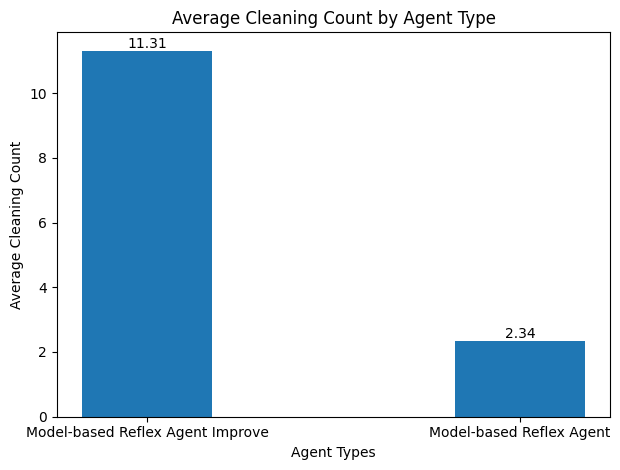

In [641]:
agent_types = ['Model-based Reflex Agent Improve', 'Model-based Reflex Agent']
max_steps = 100

# Extract average cleaning data for both agents
average_cleaning_improved = sum(result_10['Model-based Reflex Agent Improve'][max_steps]['cleanings']) / len(result_10['Model-based Reflex Agent Improve'][max_steps]['cleanings'])
average_cleaning_original = sum(result_10['Model-based Reflex Agent'][max_steps]['cleanings']) / len(result_10['Model-based Reflex Agent'][max_steps]['cleanings'])

average_cleanings = [average_cleaning_improved, average_cleaning_original]

# Create bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(agent_types))

bars = ax.bar(index, average_cleanings, bar_width)

# Labeling
ax.set_xlabel('Agent Types')
ax.set_ylabel('Average Cleaning Count')
ax.set_title('Average Cleaning Count by Agent Type')
ax.set_xticks(index)
ax.set_xticklabels(agent_types)
ax.bar_label(bars, fmt='%.2f')

# Display the plot
plt.tight_layout()
plt.show()


1. I briefly describe the above work. First, I set the misreading rate of the dirt sensor to 10%. I found that the efficiency of the original three models decreased in this case.

2. For the model-based agent, I defined a function to handle sensor errors, that is, the Bayesian update method, to deal with problems in the environment and make the model-based agent more efficient in cleaning garbage.

3. Finally, the improved model-based agent can be found from the visualization diagram that the amount of garbage cleaned is more than that of the unimproved model-based agent
In general, it is a good method to deal with the misreading of the dirt sensor through the Bayesian update method. This improved model-based reflection agent can effectively improve the room cleaning efficiency while reducing unnecessary actions, thereby achieving a balance between energy consumption and cleanliness.

## More advanced implementation tasks

* __Obstacles:__ Change your simulation environment to run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Perform experiments to observe how this changes the performance of the three implementations. Describe what would need to be done to perform better with obstacles. Add code if you can.

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actually depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currently clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [599]:
# Your ideas/code